# Distributed DeepRacer RL training with SageMaker and RoboMaker

---
## Introduction


In this notebook, we will train a fully autonomous 1/18th scale race car using reinforcement learning using Amazon SageMaker RL and AWS RoboMaker's 3D driving simulator. [AWS RoboMaker](https://console.aws.amazon.com/robomaker/home#welcome) is a service that makes it easy for developers to develop, test, and deploy robotics applications.  

This notebook provides a jailbreak experience of [AWS DeepRacer](https://console.aws.amazon.com/deepracer/home#welcome), giving us more control over the training/simulation process and RL algorithm tuning.

![Training in Action](./deepracer-reinvent-track.jpg)


---
## How it works?  

![How training works](./training.png)

The reinforcement learning agent (i.e. our autonomous car) learns to drive by interacting with its environment, e.g., the track, by taking an action in a given state to maximize the expected reward. The agent learns the optimal plan of actions in training by trial-and-error through repeated episodes.  
  
The figure above shows an example of distributed RL training across SageMaker and two RoboMaker simulation envrionments that perform the **rollouts** - execute a fixed number of episodes using the current model or policy. The rollouts collect agent experiences (state-transition tuples) and share this data with SageMaker for training. SageMaker updates the model policy which is then used to execute the next sequence of rollouts. This training loop continues until the model converges, i.e. the car learns to drive and stops going off-track. More formally, we can define the problem in terms of the following:  

1. **Objective**: Learn to drive autonomously by staying close to the center of the track.
2. **Environment**: A 3D driving simulator hosted on AWS RoboMaker.
3. **State**: The driving POV image captured by the car's head camera, as shown in the illustration above.
4. **Action**: Six discrete steering wheel positions at different angles (configurable)
5. **Reward**: Positive reward for staying close to the center line; High penalty for going off-track. This is configurable and can be made more complex (for e.g. steering penalty can be added).

## Prequisites

### Run this command only once. This will create a build directory. Later you can modify and patch it with every iteration

In [1]:
#
# Run these commands only for the first time
#
# Clean the build directory if present
!python3 sim_app_bundler.py --clean

# Download Robomaker simApp from the deepracer public s3 bucket
simulation_application_bundle_location = "s3://deepracer-managed-resources-us-east-1/deepracer-simapp.tar.gz"
!aws s3 cp {simulation_application_bundle_location} ./

# Untar the simapp bundle
!python3 sim_app_bundler.py --untar ./deepracer-simapp.tar.gz

# Now modify the simapp(Robomaker) from build directory and run this command.

# Most of the simapp files can be found here (Robomaker changes). You can modify them in these locations
# bundle/opt/install/sagemaker_rl_agent/lib/python3.5/site-packages/
# bundle/opt/install/deepracer_simulation_environment/share/deepracer_simulation_environment/
# bundle/opt/install/deepracer_simulation_environment/lib/deepracer_simulation_environment/

# # Copying the notebook src/markov changes to the simapp (For sagemaker container)
!rsync -av ./src/markov/ ./build/simapp/bundle/opt/install/sagemaker_rl_agent/lib/python3.5/site-packages/markov

print("############################################")
print("This command execution takes around >2 min...")
!python3 sim_app_bundler.py --tar

Deleting all files in ./build
download: s3://deepracer-managed-resources-us-east-1/deepracer-simapp.tar.gz to ./deepracer-simapp.tar.gz
Untarring all files in ./build/simapp/
tar -xvf ./deepracer-simapp.tar.gz -C build/simapp/
tar -xvf build/simapp/bundle.tar -C build/simapp/bundle
tar -xvf build/simapp/metadata.tar -C build/simapp/
sending incremental file list
./
__init__.py
camera_utils.py
checkpoint_utils.py
common.py
deepracer_exceptions.py
deepracer_memory.py
deepracer_memory_multi.py
defaults.py
evaluation_worker.py
rollout_utils.py
rollout_worker.py
rospy_wrappers.py
s3_boto_data_store.py
s3_client.py
s3_simdata_upload.py
sagemaker_graph_manager.py
tournament_worker.py
utils.py
utils_parse_model_metadata.py
validation_worker.py
.ipynb_checkpoints/
actions/
actions/default.json
actions/model_metadata_10_state-throtte_10.json
actions/model_metadata_10_state-throtte_3.json
actions/model_metadata_10_state.json
actions/model_metadata_15_state.json
actions/model_metadata_5_state.json

### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

You can run this notebook from your local machine or from a SageMaker notebook instance. In both of these scenarios, you can run the following to launch a training job on SageMaker and a simulation job on RoboMaker.

In [2]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import subprocess
sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from docker_utils import build_and_push_docker_image
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework
from time import gmtime, strftime
import time
from IPython.display import Markdown
from markdown_helper import *

### Initializing basic parameters

In [3]:
# Select the instance type
instance_type = "ml.c4.2xlarge"
#instance_type = "ml.p2.xlarge"
#instance_type = "ml.c5.4xlarge"

# Starting SageMaker session
sage_session = sagemaker.session.Session()

# Create unique job name.
job_name_prefix = 'deepracer-notebook'

# Duration of job in seconds (1 hours)
job_duration_in_seconds = 3600

# AWS Region
aws_region = sage_session.boto_region_name
if aws_region not in ["us-west-2", "us-east-1", "eu-west-1"]:
    raise Exception("This notebook uses RoboMaker which is available only in US East (N. Virginia),"
                    "US West (Oregon) and EU (Ireland). Please switch to one of these regions.")

### Setup S3 bucket
Set up the linkage and authentication to the S3 bucket that we want to use for checkpoint and metadata.

In [4]:
# S3 bucket
s3_bucket = sage_session.default_bucket()

# SDK appends the job name and output folder
s3_output_path = 's3://{}/'.format(s3_bucket)

#Ensure that the S3 prefix contains the keyword 'sagemaker'
s3_prefix = job_name_prefix + "-sagemaker-" + strftime("%y%m%d-%H%M%S", gmtime())

# Get the AWS account id of this account
sts = boto3.client("sts")
account_id = sts.get_caller_identity()['Account']

print("Using s3 bucket {}".format(s3_bucket))
print("Model checkpoints and other metadata will be stored at: \ns3://{}/{}".format(s3_bucket, s3_prefix))

Using s3 bucket sagemaker-us-east-1-259455987231
Model checkpoints and other metadata will be stored at: 
s3://sagemaker-us-east-1-259455987231/deepracer-notebook-sagemaker-200311-055428


### Create an IAM role
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use utils method `role = get_execution_role('role_name')` to create an execution role.

In [5]:
try:
    sagemaker_role = sagemaker.get_execution_role()
except:
    sagemaker_role = get_execution_role('sagemaker')

print("Using Sagemaker IAM role arn: \n{}".format(sagemaker_role))

Using Sagemaker IAM role arn: 
arn:aws:iam::259455987231:role/service-role/AWSDeepRacerSageMakerAccessRole


> Please note that this notebook cannot be run in `SageMaker local mode` as the simulator is based on AWS RoboMaker service.

### Permission setup for invoking AWS RoboMaker from this notebook
In order to enable this notebook to be able to execute AWS RoboMaker jobs, we need to add one trust relationship to the default execution role of this notebook.

In [6]:
display(Markdown(generate_help_for_robomaker_trust_relationship(sagemaker_role)))

1. Go to IAM console to edit current SageMaker role: [AWSDeepRacerSageMakerAccessRole](https://console.aws.amazon.com/iam/home#/roles/AWSDeepRacerSageMakerAccessRole).
2. Next, go to the `Trust relationships tab` and click on `Edit Trust Relationship.` 
3. Replace the JSON blob with the following:
```json
            {
              "Version": "2012-10-17",
              "Statement": [
                {
                  "Effect": "Allow",
                  "Principal": {
                    "Service": [
                      "sagemaker.amazonaws.com",
                      "robomaker.amazonaws.com"
                    ]
                  },
                  "Action": "sts:AssumeRole"
                }
              ]
            }```
4. Once this is complete, click on Update Trust Policy and you are done.

### Permission setup for Sagemaker to S3 bucket

The sagemaker writes the Redis IP address, models to the S3 bucket. This requires PutObject permission on the bucket. Make sure the sagemaker role you are using as this permissions.

In [7]:
display(Markdown(generate_s3_write_permission_for_sagemaker_role(sagemaker_role)))

1. Go to IAM console to edit current SageMaker role: [AWSDeepRacerSageMakerAccessRole](https://console.aws.amazon.com/iam/home#/roles/AWSDeepRacerSageMakerAccessRole).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AmazonKinesisVideoStreamsFullAccess` policy


### Permission setup for Sagemaker to create KinesisVideoStreams

The sagemaker notebook has to create a kinesis video streamer. You can observer the car making epsiodes in the kinesis video streamer.

In [8]:
display(Markdown(generate_kinesis_create_permission_for_sagemaker_role(sagemaker_role)))

1. Go to IAM console to edit current SageMaker role: [AWSDeepRacerSageMakerAccessRole](https://console.aws.amazon.com/iam/home#/roles/AWSDeepRacerSageMakerAccessRole).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AmazonS3FullAccess` policy


### Build and push docker image

The file ./Dockerfile contains all the packages that are installed into the docker. Instead of using the default sagemaker container. We will be using this docker container.

In [9]:
%%time
from copy_to_sagemaker_container import get_sagemaker_docker, copy_to_sagemaker_container, get_custom_image_name
cpu_or_gpu = 'gpu' if instance_type.startswith('ml.p') else 'cpu'
repository_short_name = "sagemaker-docker-%s" % cpu_or_gpu
custom_image_name = get_custom_image_name(repository_short_name)
try:
    print("Copying files from your notebook to existing sagemaker container")
    sagemaker_docker_id = get_sagemaker_docker(repository_short_name)
    copy_to_sagemaker_container(sagemaker_docker_id, repository_short_name)
except Exception as e:
    print("Creating sagemaker container")
    docker_build_args = {
        'CPU_OR_GPU': cpu_or_gpu, 
        'AWS_REGION': boto3.Session().region_name,
    }
    custom_image_name = build_and_push_docker_image(repository_short_name, build_args=docker_build_args)
    print("Using ECR image %s" % custom_image_name)

Copying files from your notebook to existing sagemaker container
docker images sagemaker-docker-cpu | sed -n 2,2p
Sagemaker docker id : 2060f4a077ab
docker run -d -t 2060f4a077ab
docker exec -d 0f417c5a950f976083f1118dc0095d0b7cd8c7e0da2dab0c0ac662bc02347479 rm -rf /opt/amazon/markov
docker cp ./src/markov 0f417c5a950f976083f1118dc0095d0b7cd8c7e0da2dab0c0ac662bc02347479:/opt/amazon/markov
============ Copied Markov scripts to sagemaker docker ============ 
 
docker ps -l|sed -n 2,2p
docker commit 0f417c5a950f sagemaker-docker-cpu
============ Commited all the changes to docker ============ 
 
CPU times: user 56.4 ms, sys: 27.2 ms, total: 83.6 ms
Wall time: 1.82 s


### Clean the docker images
Remove this only when you want to completely remove the docker or clean up the space of the sagemaker instance

In [10]:
# !docker rm -f $(docker ps -a -q);
# !docker rmi -f $(docker images -q);

### Configure VPC

Since SageMaker and RoboMaker have to communicate with each other over the network, both of these services need to run in VPC mode. This can be done by supplying subnets and security groups to the job launching scripts.  
We will check if the deepracer-vpc stack is created and use it if present (This is present if the AWS Deepracer console is used atleast once to create a model). Else we will use the default VPC stack.

In [11]:
ec2 = boto3.client('ec2')

#
# Check if the user has Deepracer-VPC and use that if its present. This will have all permission.
# This VPC will be created when you have used the Deepracer console and created one model atleast
# If this is not present. Use the default VPC connnection
#
deepracer_security_groups = [group["GroupId"] for group in ec2.describe_security_groups()['SecurityGroups']\
                             if group['GroupName'].startswith("aws-deepracer-")]

# deepracer_security_groups = False
if(deepracer_security_groups):
    print("Using the DeepRacer VPC stacks. This will be created if you run one training job from console.")
    deepracer_vpc = [vpc['VpcId'] for vpc in ec2.describe_vpcs()['Vpcs'] \
                     if "Tags" in vpc for val in vpc['Tags'] \
                     if val['Value'] == 'deepracer-vpc'][0]
    deepracer_subnets = [subnet["SubnetId"] for subnet in ec2.describe_subnets()["Subnets"] \
                         if subnet["VpcId"] == deepracer_vpc]
else:
    print("Using the default VPC stacks")
    deepracer_vpc = [vpc['VpcId'] for vpc in ec2.describe_vpcs()['Vpcs'] if vpc["IsDefault"] == True][0]

    deepracer_security_groups = [group["GroupId"] for group in ec2.describe_security_groups()['SecurityGroups'] \
                                 if 'VpcId' in group and group["GroupName"] == "default" and group["VpcId"] == deepracer_vpc]

    deepracer_subnets = [subnet["SubnetId"] for subnet in ec2.describe_subnets()["Subnets"] \
                         if subnet["VpcId"] == deepracer_vpc and subnet['DefaultForAz']==True]

print("Using VPC:", deepracer_vpc)
print("Using security group:", deepracer_security_groups)
print("Using subnets:", deepracer_subnets)

Using the DeepRacer VPC stacks. This will be created if you run one training job from console.
Using VPC: vpc-0f2dec0a642fc5b8c
Using security group: ['sg-0f61ebde1eed7d94c']
Using subnets: ['subnet-0d732113424f40457', 'subnet-09e600a539737d10f', 'subnet-04e5a320e8fa4a2d1', 'subnet-08301e1a04988a113', 'subnet-00a483a68911ad7ed', 'subnet-0fd59ee27bc8ea9c1']


### Create Route Table
A SageMaker job running in VPC mode cannot access S3 resourcs. So, we need to create a VPC S3 endpoint to allow S3 access from SageMaker container. To learn more about the VPC mode, please visit [this link.](https://docs.aws.amazon.com/sagemaker/latest/dg/train-vpc.html)

In [12]:
#TODO: Explain to customer what CREATE_ROUTE_TABLE is doing
CREATE_ROUTE_TABLE = True

def create_vpc_endpoint_table():
    print("Creating ")
    try:
        route_tables = [route_table["RouteTableId"] for route_table in ec2.describe_route_tables()['RouteTables']\
                        if route_table['VpcId'] == deepracer_vpc]
    except Exception as e:
        if "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(sagemaker_role)))
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
        raise e

    print("Trying to attach S3 endpoints to the following route tables:", route_tables)
    
    if not route_tables:
        raise Exception(("No route tables were found. Please follow the VPC S3 endpoint creation "
                         "guide by clicking the above link."))
    try:
        ec2.create_vpc_endpoint(DryRun=False,
                                VpcEndpointType="Gateway",
                                VpcId=deepracer_vpc,
                                ServiceName="com.amazonaws.{}.s3".format(aws_region),
                                RouteTableIds=route_tables)
        print("S3 endpoint created successfully!")
    except Exception as e:
        if "RouteAlreadyExists" in str(e):
            print("S3 endpoint already exists.")
        elif "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(role)))
            raise e
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
            raise e

if CREATE_ROUTE_TABLE:
    create_vpc_endpoint_table()

Creating 
Trying to attach S3 endpoints to the following route tables: ['rtb-05188842a86b07ea9', 'rtb-02504a1ac8688cbdb']
S3 endpoint already exists.


## Setup the environment

The environment is defined in a Python file called “deepracer_racetrack_env.py” and the file can be found at `src/markov/environments/`. This file implements the gym interface for our Gazebo based RoboMakersimulator. This is a common environment file used by both SageMaker and RoboMaker. The environment variable - `NODE_TYPE` defines which node the code is running on. So, the expressions that have `rospy` dependencies are executed on RoboMaker only.  

We can experiment with different reward functions by modifying `reward_function` in `src/markov/rewards/`. Action space and steering angles can be changed by modifying `src/markov/actions/`.json file

### Configure the preset for RL algorithm

The parameters that configure the RL training job are defined in `src/markov/presets/`. Using the preset file, you can define agent parameters to select the specific agent algorithm. We suggest using Clipped PPO for this example.  
You can edit this file to modify algorithm parameters like learning_rate, neural network structure, batch_size, discount factor etc.

In [13]:
# Uncomment the pygmentize code lines to see the code

# Reward function
#!pygmentize src/markov/rewards/default.py

# Action space
#!pygmentize src/markov/actions/single_speed_stereo_shallow.json

# Preset File
#!pygmentize src/markov/presets/default.py
#!pygmentize src/markov/presets/preset_attention_layer.py

### Copy custom files to S3 bucket so that sagemaker & robomaker can pick it up

In [14]:
s3_location = "s3://%s/%s" % (s3_bucket, s3_prefix)
print(s3_location)

# Clean up the previously uploaded files
!aws s3 rm --recursive {s3_location}

!aws s3 cp src/markov/rewards/default.py {s3_location}/customer_reward_function.py

!aws s3 cp src/markov/actions/default.json {s3_location}/model/model_metadata.json

#!aws s3 cp src/markov/presets/default.py {s3_location}/presets/preset.py
#!aws s3 cp src/markov/presets/preset_attention_layer.py {s3_location}/presets/preset.py

s3://sagemaker-us-east-1-259455987231/deepracer-notebook-sagemaker-200311-055428
upload: src/markov/rewards/default.py to s3://sagemaker-us-east-1-259455987231/deepracer-notebook-sagemaker-200311-055428/customer_reward_function.py
upload: src/markov/actions/default.json to s3://sagemaker-us-east-1-259455987231/deepracer-notebook-sagemaker-200311-055428/model/model_metadata.json


### Train the RL model using the Python SDK Script mode

Next, we define the following algorithm metrics that we want to capture from cloudwatch logs to monitor the training progress. These are algorithm specific parameters and might change for different algorithm. We use [Clipped PPO](https://coach.nervanasys.com/algorithms/policy_optimization/cppo/index.html) for this example.

In [15]:
metric_definitions = [
    # Training> Name=main_level/agent, Worker=0, Episode=19, Total reward=-102.88, Steps=19019, Training iteration=1
    {'Name': 'reward-training',
     'Regex': '^Training>.*Total reward=(.*?),'},
    
    # Policy training> Surrogate loss=-0.32664725184440613, KL divergence=7.255815035023261e-06, Entropy=2.83156156539917, training epoch=0, learning_rate=0.00025
    {'Name': 'ppo-surrogate-loss',
     'Regex': '^Policy training>.*Surrogate loss=(.*?),'},
     {'Name': 'ppo-entropy',
     'Regex': '^Policy training>.*Entropy=(.*?),'},
   
    # Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=1359.12, Steps=20015, Training iteration=2
    {'Name': 'reward-testing',
     'Regex': '^Testing>.*Total reward=(.*?),'},
]

We use the RLEstimator for training RL jobs.

1. Specify the source directory which has the environment file, preset and training code.
2. Specify the entry point as the training code
3. Specify the choice of RL toolkit and framework. This automatically resolves to the ECR path for the RL Container.
4. Define the training parameters such as the instance count, instance type, job name, s3_bucket and s3_prefix for storing model checkpoints and metadata. **Only 1 training instance is supported for now.**
4. Set the RLCOACH_PRESET as "deepracer" for this example.
5. Define the metrics definitions that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks.

In [16]:
estimator = RLEstimator(entry_point="training_worker.py",
                        source_dir='src',
                        image_name=custom_image_name,
                        dependencies=["common/"],
                        role=sagemaker_role,
                        train_instance_type=instance_type,
                        train_instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        metric_definitions=metric_definitions,
                        train_max_run=job_duration_in_seconds,
                        hyperparameters={
                            "s3_bucket": s3_bucket,
                            "s3_prefix": s3_prefix,
                            "aws_region": aws_region,
                            "model_metadata_s3_key": "%s/model/model_metadata.json" % s3_prefix,
                            "reward_function_s3_source": "%s/customer_reward_function.py" % s3_prefix,
                            "batch_size": "64",
                            "num_epochs": "10",
                            "stack_size": "1",
                            "lr": "0.0003",
                            "exploration_type": "Categorical",
                            "e_greedy_value": "1",
                            "epsilon_steps": "10000",
                            "beta_entropy": "0.01",
                            "discount_factor": "0.999",
                            "loss_type": "Huber",
                            "num_episodes_between_training": "20",
                            "max_sample_count": "0",
                            "sampling_frequency": "1"
                        },
                        subnets=deepracer_subnets,
                        security_group_ids=deepracer_security_groups,
                    )

estimator.fit(wait=False)
job_name = estimator.latest_training_job.job_name
print("Training job: %s" % job_name)

Training job: deepracer-notebook-2020-03-11-05-54-33-793


In [17]:
training_job_arn = estimator.latest_training_job.describe()['TrainingJobArn']

### Create the Kinesis video stream

In [18]:
kvs_stream_name = "dr-kvs-{}".format(job_name)

!aws --region {aws_region} kinesisvideo create-stream --stream-name {kvs_stream_name} --media-type video/h264 --data-retention-in-hours 24
print ("Created kinesis video stream {}".format(kvs_stream_name))

{
    "StreamARN": "arn:aws:kinesisvideo:us-east-1:259455987231:stream/dr-kvs-deepracer-notebook-2020-03-11-05-54-33-793/1583906074950"
}
Created kinesis video stream dr-kvs-deepracer-notebook-2020-03-11-05-54-33-793


### Start the Robomaker job

In [19]:
robomaker = boto3.client("robomaker")

### Create Simulation Application

In [20]:
robomaker_s3_key = 'robomaker/simulation_ws.tar.gz'
robomaker_source = {'s3Bucket': s3_bucket,
                    's3Key': robomaker_s3_key,
                    'architecture': "X86_64"}
simulation_software_suite={'name': 'Gazebo',
                           'version': '7'}
robot_software_suite={'name': 'ROS',
                      'version': 'Kinetic'}
rendering_engine={'name': 'OGRE',
                  'version': '1.x'}

Download the DeepRacer bundle provided by RoboMaker service and upload it in our S3 bucket to create a RoboMaker Simulation Application

In [21]:
if not os.path.exists('./build/output.tar.gz'):
    print("Using the latest simapp from public s3 bucket")
    # Download Robomaker simApp for the deepracer public s3 bucket
    simulation_application_bundle_location = "s3://deepracer-managed-resources-us-east-1/deepracer-simapp.tar.gz"
    !aws s3 cp {simulation_application_bundle_location} ./

    # Remove if the Robomaker sim-app is present in s3 bucket
    !aws s3 rm s3://{s3_bucket}/{robomaker_s3_key}

    # Uploading the Robomaker SimApp to your S3 bucket
    !aws s3 cp ./deepracer-simapp.tar.gz s3://{s3_bucket}/{robomaker_s3_key}

    # Cleanup the locally downloaded version of SimApp
    !rm deepracer-simapp.tar.gz
else:
    print("Using the simapp from build directory")
    !aws s3 cp ./build/output.tar.gz s3://{s3_bucket}/{robomaker_s3_key}

Using the simapp from build directory
upload: build/output.tar.gz to s3://sagemaker-us-east-1-259455987231/robomaker/simulation_ws.tar.gz


In [22]:
app_name = "deepracer-notebook-application" + strftime("%y%m%d-%H%M%S", gmtime())

print(app_name)
try:
    response = robomaker.create_simulation_application(name=app_name,
                                                       sources=[robomaker_source],
                                                       simulationSoftwareSuite=simulation_software_suite,
                                                       robotSoftwareSuite=robot_software_suite,
                                                       renderingEngine=rendering_engine)
    simulation_app_arn = response["arn"]
    print("Created a new simulation app with ARN:", simulation_app_arn)
except Exception as e:
    if "AccessDeniedException" in str(e):
        display(Markdown(generate_help_for_robomaker_all_permissions(role)))
        raise e
    else:
        raise e

deepracer-notebook-application200311-055451
Created a new simulation app with ARN: arn:aws:robomaker:us-east-1:259455987231:simulation-application/deepracer-notebook-application200311-055451/1583906091281


### Launch the Simulation job on RoboMaker

We create [AWS RoboMaker](https://console.aws.amazon.com/robomaker/home#welcome) Simulation Jobs that simulates the environment and shares this data with SageMaker for training. 

In [23]:
s3_yaml_name="training_params.yaml"
world_name = "reInvent2019_track"

!touch {s3_yaml_name}
!echo "WORLD_NAME:                           \"{world_name}\"" | tee {s3_yaml_name}
!echo "SAGEMAKER_SHARED_S3_BUCKET:           \"{s3_bucket}\"" | tee -a {s3_yaml_name}
!echo "SAGEMAKER_SHARED_S3_PREFIX:           \"{s3_prefix}\"" | tee -a {s3_yaml_name}
!echo "TRAINING_JOB_ARN:                     \"{training_job_arn}\"" | tee -a {s3_yaml_name}
!echo "METRICS_S3_BUCKET:                    \"{s3_bucket}\"" | tee -a {s3_yaml_name}
!echo "METRICS_S3_OBJECT_KEY:                \"{s3_prefix}/training_metrics.json\"" | tee -a {s3_yaml_name}
!echo "SIMTRACE_S3_BUCKET:                   \"{s3_bucket}\"" | tee -a {s3_yaml_name}
!echo "SIMTRACE_S3_PREFIX:                   \"{s3_prefix}/iteration-data/training\"" | tee -a {s3_yaml_name}
!echo "MP4_S3_BUCKET:                        \"{s3_bucket}\"" | tee -a {s3_yaml_name}
!echo "MP4_S3_OBJECT_PREFIX:                 \"{s3_prefix}/iteration-data/training\"" | tee -a {s3_yaml_name}
!echo "AWS_REGION:                           \"{aws_region}\"" | tee -a {s3_yaml_name}
!echo "TARGET_REWARD_SCORE:                  \"None\"" | tee -a {s3_yaml_name}
!echo "NUMBER_OF_EPISODES:                   \"0\"" | tee -a {s3_yaml_name}
!echo "ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID:  \"{account_id}\"" | tee -a {s3_yaml_name}
!echo "JOB_TYPE:                             \"TRAINING\"" | tee -a {s3_yaml_name}
!echo "CHANGE_START_POSITION:                \"true\"" | tee -a {s3_yaml_name}
!echo "ALTERNATE_DRIVING_DIRECTION:          \"false\"" | tee -a {s3_yaml_name}
!echo "KINESIS_VIDEO_STREAM_NAME:            \"{kvs_stream_name}\"" | tee -a {s3_yaml_name}
!echo "REWARD_FILE_S3_KEY:                   \"{s3_prefix}/customer_reward_function.py\"" | tee -a {s3_yaml_name}
!echo "MODEL_METADATA_FILE_S3_KEY:           \"{s3_prefix}/model/model_metadata.json\"" | tee -a {s3_yaml_name}

!echo "NUMBER_OF_OBSTACLES:                  \"0\"" | tee -a {s3_yaml_name}
!echo "MIN_DISTANCE_BETWEEN_OBSTACLES:       \"2.0\"" | tee -a {s3_yaml_name}
!echo "RANDOMIZE_OBSTACLE_LOCATIONS:         \"false\"" | tee -a {s3_yaml_name}
!echo "PSEUDO_RANDOMIZE_OBSTACLE_LOCATIONS:  \"false\"" | tee -a {s3_yaml_name}
!echo "NUMBER_OF_PSEUDO_RANDOM_PLACEMENTS:   \"2\"" | tee -a {s3_yaml_name}
!echo "IS_OBSTACLE_BOT_CAR:                  \"false\"" | tee -a {s3_yaml_name}

!echo "IS_LANE_CHANGE:                       \"false\"" | tee -a {s3_yaml_name}
!echo "LOWER_LANE_CHANGE_TIME:               \"3.0\"" | tee -a {s3_yaml_name}
!echo "UPPER_LANE_CHANGE_TIME:               \"5.0\"" | tee -a {s3_yaml_name}
!echo "LANE_CHANGE_DISTANCE:                 \"1.0\"" | tee -a {s3_yaml_name}

!echo "NUMBER_OF_BOT_CARS:                   \"6\"" | tee -a {s3_yaml_name}
!echo "MIN_DISTANCE_BETWEEN_BOT_CARS:        \"2.0\"" | tee -a {s3_yaml_name}
!echo "RANDOMIZE_BOT_CAR_LOCATIONS:          \"false\"" | tee -a {s3_yaml_name}
!echo "BOT_CAR_SPEED:                        \"0.2\"" | tee -a {s3_yaml_name}
!echo "CAR_COLOR:                            \"Blue\"" | tee -a {s3_yaml_name}
!echo "NUMBER_OF_RESETS:                     \"0\"" | tee -a {s3_yaml_name}
!echo "RACE_TYPE:                            \"HEAD_TO_BOT\"" | tee -a {s3_yaml_name}
!echo "DISPLAY_NAME:                         \"Racer1\"" | tee -a {s3_yaml_name}


print("Upload yaml settings to S3")
!aws s3 cp ./training_params.yaml {s3_location}/training_params.yaml
!rm training_params.yaml

WORLD_NAME:                           "reInvent2019_track"
SAGEMAKER_SHARED_S3_BUCKET:           "sagemaker-us-east-1-259455987231"
SAGEMAKER_SHARED_S3_PREFIX:           "deepracer-notebook-sagemaker-200311-055428"
TRAINING_JOB_ARN:                     "arn:aws:sagemaker:us-east-1:259455987231:training-job/deepracer-notebook-2020-03-11-05-54-33-793"
METRICS_S3_BUCKET:                    "sagemaker-us-east-1-259455987231"
METRICS_S3_OBJECT_KEY:                "deepracer-notebook-sagemaker-200311-055428/training_metrics.json"
SIMTRACE_S3_BUCKET:                   "sagemaker-us-east-1-259455987231"
SIMTRACE_S3_PREFIX:                   "deepracer-notebook-sagemaker-200311-055428/iteration-data/training"
MP4_S3_BUCKET:                        "sagemaker-us-east-1-259455987231"
MP4_S3_OBJECT_PREFIX:                 "deepracer-notebook-sagemaker-200311-055428/iteration-data/training"
AWS_REGION:                           "us-east-1"
TARGET_REWARD_SCORE:                  "None"
NUMBER_OF_EPISO

In [24]:
num_simulation_workers = 2

envriron_vars = {
    "S3_YAML_NAME": s3_yaml_name,
    "SAGEMAKER_SHARED_S3_PREFIX": s3_prefix,
    "SAGEMAKER_SHARED_S3_BUCKET": s3_bucket,
    "WORLD_NAME": world_name,
    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
    "APP_REGION": aws_region,
    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix
}

simulation_application = {"application":simulation_app_arn,
                          "launchConfig": {"packageName": "deepracer_simulation_environment",
                                           "launchFile": "distributed_training.launch",
                                           "environmentVariables": envriron_vars}
                         }


vpcConfig = {"subnets": deepracer_subnets,
             "securityGroups": deepracer_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    client_request_token = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
    response =  robomaker.create_simulation_job(iamRole=sagemaker_role,
                                            clientRequestToken=client_request_token,
                                            maxJobDurationInSeconds=job_duration_in_seconds,
                                            failureBehavior="Continue",
                                            simulationApplications=[simulation_application],
                                            vpcConfig=vpcConfig
                                            )
    responses.append(response)

print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

Created the following jobs:
Job ARN arn:aws:robomaker:us-east-1:259455987231:simulation-job/sim-4yrmb5v3fhmy
Job ARN arn:aws:robomaker:us-east-1:259455987231:simulation-job/sim-5zjq7gtthgkg


### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [25]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

> Click on the following links for visualization of simulation jobs on RoboMaker Console
- [Simulation 1](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-4yrmb5v3fhmy)  
- [Simulation 2](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-5zjq7gtthgkg)  

You can click on Gazebo after you open the above link to start the simulator.

### Creating temporary folder top plot metrics

In [54]:
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Create local folder /tmp/deepracer-notebook-2020-03-11-04-19-31-901


### Plot metrics for training job

Waiting for s3://sagemaker-us-east-1-259455987231/deepracer-notebook-sagemaker-200311-041910/training_metrics.json...


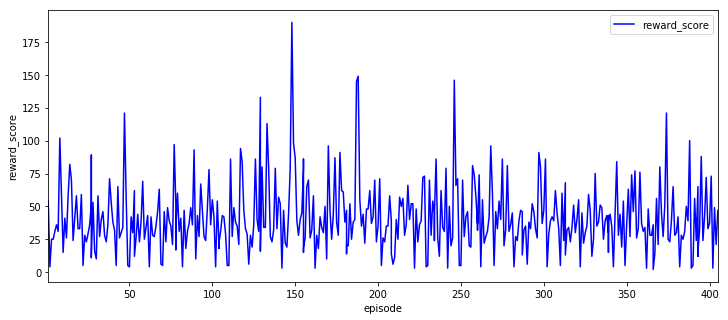

In [55]:
%matplotlib inline
import pandas as pd
import json

training_metrics_file = "training_metrics.json"
training_metrics_path = "{}/{}".format(s3_prefix, training_metrics_file)
wait_for_s3_object(s3_bucket, training_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, training_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df = pd.DataFrame(data['metrics'])
x_axis = 'episode'
y_axis = 'reward_score'

plt = df.plot(x=x_axis,y=y_axis, figsize=(12,5), legend=True, style='b-')
plt.set_ylabel(y_axis);
plt.set_xlabel(x_axis);

### Clean up RoboMaker and SageMaker training job

Execute the cells below if you want to kill RoboMaker and SageMaker job.

In [56]:
# # Cancelling robomaker job
# for job_arn in job_arns:
#     robomaker.cancel_simulation_job(job=job_arn)

# # Stopping sagemaker training job
# sage_session.sagemaker_client.stop_training_job(TrainingJobName=estimator._current_job_name)

## Evaluation

In [57]:
s3_yaml_name="evaluation_params.yaml"
world_name = "reInvent2019_track"

!touch {s3_yaml_name}
!echo "WORLD_NAME:                           \"{world_name}\"" | tee {s3_yaml_name}
!echo "MODEL_S3_BUCKET:                      \"{s3_bucket}\"" | tee -a {s3_yaml_name}
!echo "MODEL_S3_PREFIX:                      \"{s3_prefix}\"" | tee -a {s3_yaml_name}
!echo "AWS_REGION:                           \"{aws_region}\"" | tee -a {s3_yaml_name}
!echo "METRICS_S3_BUCKET:                    \"{s3_bucket}\"" | tee -a {s3_yaml_name}
!echo "METRICS_S3_OBJECT_KEY:                \"{s3_prefix}/evaluation_metrics.json\"" | tee -a {s3_yaml_name}
!echo "SIMTRACE_S3_BUCKET:                   \"{s3_bucket}\"" | tee -a {s3_yaml_name}
!echo "SIMTRACE_S3_PREFIX:                   \"{s3_prefix}/iteration-data/evaluation\"" | tee -a {s3_yaml_name}
!echo "MP4_S3_BUCKET:                        \"{s3_bucket}\"" | tee -a {s3_yaml_name}
!echo "MP4_S3_OBJECT_PREFIX:                 \"{s3_prefix}/iteration-data/evaluation\"" | tee -a {s3_yaml_name}
!echo "NUMBER_OF_TRIALS:                     \"5\"" | tee -a {s3_yaml_name}
!echo "ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID:  \"{account_id}\"" | tee -a {s3_yaml_name}
!echo "JOB_TYPE:                             \"EVALUATION\"" | tee -a {s3_yaml_name}

!echo "NUMBER_OF_OBSTACLES:                  \"0\"" | tee -a {s3_yaml_name}
!echo "MIN_DISTANCE_BETWEEN_OBSTACLES:       \"2.0\"" | tee -a {s3_yaml_name}
!echo "RANDOMIZE_OBSTACLE_LOCATIONS:         \"false\"" | tee -a {s3_yaml_name}
!echo "PSEUDO_RANDOMIZE_OBSTACLE_LOCATIONS:  \"false\"" | tee -a {s3_yaml_name}
!echo "NUMBER_OF_PSEUDO_RANDOM_PLACEMENTS:   \"2\"" | tee -a {s3_yaml_name}
!echo "IS_OBSTACLE_BOT_CAR:                  \"false\"" | tee -a {s3_yaml_name}  

!echo "IS_LANE_CHANGE:                       \"false\"" | tee -a {s3_yaml_name}
!echo "LOWER_LANE_CHANGE_TIME:               \"3.0\"" | tee -a {s3_yaml_name}
!echo "UPPER_LANE_CHANGE_TIME:               \"5.0\"" | tee -a {s3_yaml_name}
!echo "LANE_CHANGE_DISTANCE:                 \"1.0\"" | tee -a {s3_yaml_name}

!echo "NUMBER_OF_BOT_CARS:                   \"6\"" | tee -a {s3_yaml_name}
!echo "MIN_DISTANCE_BETWEEN_BOT_CARS:        \"2.0\"" | tee -a {s3_yaml_name}
!echo "RANDOMIZE_BOT_CAR_LOCATIONS:          \"true\"" | tee -a {s3_yaml_name}
!echo "BOT_CAR_SPEED:                        \"0.2\"" | tee -a {s3_yaml_name}
!echo "CAR_COLOR:                            \"Blue\"" | tee -a {s3_yaml_name}
!echo "NUMBER_OF_RESETS:                     \"10000\"" | tee -a {s3_yaml_name}
!echo "PENALTY_SECONDS:                      \"2.0\"" | tee -a {s3_yaml_name}
!echo "IS_CONTINUOUS:                        \"false\"" | tee -a {s3_yaml_name}
!echo "RACE_TYPE:                            \"HEAD_TO_BOT\"" | tee -a {s3_yaml_name}
!echo "OFF_TRACK_PENALTY:                    \"2.0\"" | tee -a {s3_yaml_name}
!echo "COLLISION_PENALTY:                    \"5.0\"" | tee -a {s3_yaml_name}
# echo "OBJECT_POSITIONS:
#  - 0.25, +1
#  - 0.09, -1" | tee -a ${S3_YAML_NAME}
!echo "DISPLAY_NAME:                         \"Racer1\"" | tee -a {S3_YAML_NAME}

print("Upload yaml settings to S3")
!aws s3 cp ./evaluation_params.yaml {s3_location}/evaluation_params.yaml

WORLD_NAME:                           "reInvent2019_track"
MODEL_S3_BUCKET:                      "sagemaker-us-east-1-259455987231"
MODEL_S3_PREFIX:                      "deepracer-notebook-sagemaker-200311-041910"
AWS_REGION:                           "us-east-1"
METRICS_S3_BUCKET:                    "sagemaker-us-east-1-259455987231"
METRICS_S3_OBJECT_KEY:                "deepracer-notebook-sagemaker-200311-041910/evaluation_metrics.json"
SIMTRACE_S3_BUCKET:                   "sagemaker-us-east-1-259455987231"
SIMTRACE_S3_PREFIX:                   "deepracer-notebook-sagemaker-200311-041910/iteration-data/evaluation"
MP4_S3_BUCKET:                        "sagemaker-us-east-1-259455987231"
MP4_S3_OBJECT_PREFIX:                 "deepracer-notebook-sagemaker-200311-041910/iteration-data/evaluation"
NUMBER_OF_TRIALS:                     "5"
ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID:  "259455987231"
JOB_TYPE:                             "EVALUATION"
NUMBER_OF_OBSTACLES:                  "0"
MIN

In [58]:
sys.path.append("./src")

num_simulation_workers = 1

envriron_vars = {
    "S3_YAML_NAME": s3_yaml_name,
    "MODEL_S3_PREFIX": s3_prefix,
    "MODEL_S3_BUCKET": s3_bucket,
    "WORLD_NAME": world_name,
    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
    "APP_REGION": aws_region,
    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix
}

simulation_application = {
    "application":simulation_app_arn,
    "launchConfig": {
         "packageName": "deepracer_simulation_environment",
         "launchFile": "evaluation.launch",
         "environmentVariables": envriron_vars
    }
}
                            
vpcConfig = {"subnets": deepracer_subnets,
             "securityGroups": deepracer_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    response =  robomaker.create_simulation_job(clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
                                                outputLocation={ 
                                                  "s3Bucket": s3_bucket,
                                                  "s3Prefix": s3_prefix
                                                },
                                                maxJobDurationInSeconds=job_duration_in_seconds,
                                                iamRole=sagemaker_role,
                                                failureBehavior="Continue",
                                                simulationApplications=[simulation_application],
                                                vpcConfig=vpcConfig)
    responses.append(response)

print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

Created the following jobs:
Job ARN arn:aws:robomaker:us-east-1:259455987231:simulation-job/sim-r63dl27k36tw


### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [59]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

> Click on the following links for visualization of simulation jobs on RoboMaker Console
- [Simulation 1](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-r63dl27k36tw)  

You can click on Gazebo after you open the above link to start the simulator.

### Creating temporary folder top plot metrics

In [63]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix, evaluation_metrics_file)
wait_for_s3_object(s3_bucket, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df = pd.DataFrame(data['metrics'])
# Converting milliseconds to seconds
df['elapsed_time'] = df['elapsed_time_in_milliseconds']/1000
df = df[['trial', 'completion_percentage', 'elapsed_time']]

display(df)

Waiting for s3://sagemaker-us-east-1-259455987231/deepracer-notebook-sagemaker-200311-041910/evaluation_metrics.json...


,trial,completion_percentage,elapsed_time
0,1,100,67.626
1,2,100,88.165
2,3,100,50.355
3,4,100,63.575
4,5,100,66.252


### Clean Up Simulation Application Resource

In [ ]:
# robomaker.delete_simulation_application(application=simulation_app_arn)

### Clean your S3 bucket (Uncomment the awscli commands if you want to do it)

In [ ]:
## Uncomment if you only want to clean the s3 bucket
# sagemaker_s3_folder = "s3://{}/{}".format(s3_bucket, s3_prefix)
# !aws s3 rm --recursive {sagemaker_s3_folder}

# robomaker_s3_folder = "s3://{}/{}".format(s3_bucket, job_name)
# !aws s3 rm --recursive {robomaker_s3_folder}

# robomaker_sim_app = "s3://{}/{}".format(s3_bucket, 'robomaker')
# !aws s3 rm --recursive {robomaker_sim_app}

# model_output = "s3://{}/{}".format(s3_bucket, s3_bucket)
# !aws s3 rm --recursive {model_output}

## Head-to-head Evaluation

In [68]:
# S3 bucket
s3_bucket_2 = sage_session.default_bucket()

#Ensure that the S3 prefix contains the keyword 'sagemaker'
# s3_prefix_2 = "deepracer-notebook-sagemaker-200311-034959"
s3_prefix_2 = ""
if not s3_prefix_2:
    raise Exception("Please provide the second agents s3_prefix and s3_bucket. The prefix would have sagemaker in between")

print("Using s3 bucket {}".format(s3_bucket_2))
print("Model checkpoints and other metadata will be stored at: \ns3://{}/{}".format(s3_bucket_2, s3_prefix_2))

Using s3 bucket sagemaker-us-east-1-259455987231
Model checkpoints and other metadata will be stored at: 
s3://sagemaker-us-east-1-259455987231/deepracer-notebook-sagemaker-200311-034959


In [69]:
s3_yaml_name="evaluation_params.yaml"
world_name = "reInvent2019_track"

!touch {s3_yaml_name}
!echo "WORLD_NAME:                           \"{world_name}\"" | tee {s3_yaml_name}
!echo -e "MODEL_S3_BUCKET:\n - {s3_bucket}\n - {s3_bucket_2}" | tee -a {s3_yaml_name}
!echo -e "MODEL_S3_PREFIX:\n - {s3_prefix}\n - {s3_prefix_2}" | tee -a {s3_yaml_name}
!echo "AWS_REGION:                           \"{aws_region}\"" | tee -a {s3_yaml_name}
!echo -e "METRICS_S3_BUCKET:\n - {s3_bucket}\n - {s3_bucket_2}" | tee -a {s3_yaml_name}
!echo -e "METRICS_S3_OBJECT_KEY:\n - {s3_prefix}/evaluation_metrics.json\n - {s3_prefix_2}/evaluation_metrics.json" | tee -a {s3_yaml_name}
!echo -e "MODEL_METADATA_FILE_S3_KEY:\n - {s3_prefix}/model/model_metadata.json\n - {s3_prefix_2}/model/model_metadata.json" | tee -a {s3_yaml_name}
!echo -e "SIMTRACE_S3_BUCKET:\n - {s3_bucket}\n - {s3_bucket_2}" | tee -a {s3_yaml_name}
!echo -e "SIMTRACE_S3_PREFIX:\n - {s3_prefix}/iteration-data/evaluation\n - {s3_prefix_2}/iteration-data/evaluation" | tee -a {s3_yaml_name}
!echo -e "MP4_S3_BUCKET:\n - {s3_bucket}\n - {s3_bucket_2}" | tee -a {s3_yaml_name}
!echo -e "MP4_S3_OBJECT_PREFIX:\n - {s3_prefix}/iteration-data/evaluation\n - {s3_prefix_2}/iteration-data/evaluation" | tee -a {s3_yaml_name}
!echo "NUMBER_OF_TRIALS:                     \"3\"" | tee -a {s3_yaml_name}
!echo "ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID:  \"${account_id}\"" | tee -a {s3_yaml_name}
!echo "JOB_TYPE:                             \"EVALUATION\"" | tee -a {s3_yaml_name}
!echo "MULTICAR:                             \"true\"" | tee -a {s3_yaml_name}
!echo -e "CAR_COLOR:\n - White\n - Black" | tee -a {s3_yaml_name}
!echo "IS_CONTINUOUS:                        \"false\"" | tee -a {s3_yaml_name}
!echo "NUMBER_OF_RESETS:                     \"10000\"" | tee -a {s3_yaml_name}
!echo "PENALTY_SECONDS:                      \"2.0\"" | tee -a {s3_yaml_name}
!echo "RACE_TYPE:                            \"HEAD_TO_MODEL\"" | tee -a {s3_yaml_name}
!echo "OFF_TRACK_PENALTY:                    \"2.0\"" | tee -a {s3_yaml_name}
!echo "COLLISION_PENALTY:                    \"5.0\"" | tee -a {s3_yaml_name}
!echo -e "DISPLAY_NAME:\n - Racer1LongLongRacerNameBlaBlaBla\n - Racer2LongLongRacerNameBlaBlaBla" | tee -a {s3_yaml_name}
#############
# obstacles #
#############
# !echo "NUMBER_OF_OBSTACLES:                  \"6\"" | tee -a {s3_yaml_name}
# !echo "MIN_DISTANCE_BETWEEN_OBSTACLES:       \"2.0\"" | tee -a {s3_yaml_name}
# !echo "IS_OBSTACLE_BOT_CAR:                  \"true\"" | tee -a {s3_yaml_name}
# !echo "RANDOMIZE_OBSTACLE_LOCATIONS:         \"true\"" | tee -a {s3_yaml_name}
# !echo "PSEUDO_RANDOMIZE_OBSTACLE_LOCATIONS:  \"true\"" | tee -a {s3_yaml_name}
# !echo "NUMBER_OF_PSEUDO_RANDOM_PLACEMENTS:   \"2\"" | tee -a {s3_yaml_name}

###############
# time trials #
###############
# !echo "NUMBER_OF_OBSTACLES:                  \"0\"" | tee -a {s3_yaml_name}
# !echo "MIN_DISTANCE_BETWEEN_OBSTACLES:       \"2.0\"" | tee -a {s3_yaml_name}
# !echo "RANDOMIZE_OBSTACLE_LOCATIONS:         \"false\"" | tee -a {s3_yaml_name}
# !echo "PSEUDO_RANDOMIZE_OBSTACLE_LOCATIONS:  \"false\"" | tee -a {s3_yaml_name}
# !echo "NUMBER_OF_PSEUDO_RANDOM_PLACEMENTS:   \"2\"" | tee -a {s3_yaml_name}
# !echo "IS_OBSTACLE_BOT_CAR:                  \"false\"" | tee -a {s3_yaml_name}  

###########
# bot car #
###########
!echo "IS_LANE_CHANGE:                       \"false\"" | tee -a {s3_yaml_name}
!echo "LOWER_LANE_CHANGE_TIME:               \"1.0\"" | tee -a {s3_yaml_name}
!echo "UPPER_LANE_CHANGE_TIME:               \"10.0\"" | tee -a {s3_yaml_name}
!echo "LANE_CHANGE_DISTANCE:                 \"1.0\"" | tee -a {s3_yaml_name}
!echo "NUMBER_OF_BOT_CARS:                   \"0\"" | tee -a {s3_yaml_name}
!echo "MIN_DISTANCE_BETWEEN_BOT_CARS:        \"2.0\"" | tee -a {s3_yaml_name}
!echo "RANDOMIZE_BOT_CAR_LOCATIONS:          \"true\"" | tee -a {s3_yaml_name}
!echo "BOT_CAR_SPEED:                        \"0.2\"" | tee -a {s3_yaml_name}


print("Upload yaml settings to S3")
!aws s3 cp ./evaluation_params.yaml {s3_location}/evaluation_params.yaml

WORLD_NAME:                           "reInvent2019_track"
MODEL_S3_BUCKET:
 - sagemaker-us-east-1-259455987231
 - sagemaker-us-east-1-259455987231
MODEL_S3_PREFIX:
 - deepracer-notebook-sagemaker-200311-041910
 - deepracer-notebook-sagemaker-200311-034959
AWS_REGION:                           "us-east-1"
METRICS_S3_BUCKET:
 - sagemaker-us-east-1-259455987231
 - sagemaker-us-east-1-259455987231
METRICS_S3_OBJECT_KEY:
 - deepracer-notebook-sagemaker-200311-041910/evaluation_metrics.json
 - deepracer-notebook-sagemaker-200311-034959/evaluation_metrics.json
MODEL_METADATA_FILE_S3_KEY:
 - deepracer-notebook-sagemaker-200311-041910/model/model_metadata.json
 - deepracer-notebook-sagemaker-200311-034959/model/model_metadata.json
SIMTRACE_S3_BUCKET:
 - sagemaker-us-east-1-259455987231
 - sagemaker-us-east-1-259455987231
SIMTRACE_S3_PREFIX:
 - deepracer-notebook-sagemaker-200311-041910/iteration-data/evaluation
 - deepracer-notebook-sagemaker-200311-034959/iteration-data/evaluation
MP4_S3_BUCK

In [70]:
sys.path.append("./src")

num_simulation_workers = 1

envriron_vars = {
    "S3_YAML_NAME": s3_yaml_name,
    "MODEL_S3_PREFIX": s3_prefix,
    "MODEL_S3_BUCKET": s3_bucket,
    "WORLD_NAME": world_name,
    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
    "APP_REGION": aws_region,
    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix
}

simulation_application = {
    "application":simulation_app_arn,
    "launchConfig": {
         "packageName": "deepracer_simulation_environment",
         "launchFile": "evaluation.launch",
         "environmentVariables": envriron_vars
    }
}
                            
vpcConfig = {"subnets": deepracer_subnets,
             "securityGroups": deepracer_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    response =  robomaker.create_simulation_job(clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
                                                outputLocation={ 
                                                  "s3Bucket": s3_bucket,
                                                  "s3Prefix": s3_prefix
                                                },
                                                maxJobDurationInSeconds=job_duration_in_seconds,
                                                iamRole=sagemaker_role,
                                                failureBehavior="Continue",
                                                simulationApplications=[simulation_application],
                                                vpcConfig=vpcConfig)
    responses.append(response)

print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

Created the following jobs:
Job ARN arn:aws:robomaker:us-east-1:259455987231:simulation-job/sim-yd8z9prqxwsw


### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [71]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

> Click on the following links for visualization of simulation jobs on RoboMaker Console
- [Simulation 1](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-yd8z9prqxwsw)  

You can click on Gazebo after you open the above link to start the simulator.

### Creating temporary folder top plot metrics

In [73]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix, evaluation_metrics_file)
wait_for_s3_object(s3_bucket, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df_1 = pd.DataFrame(data['metrics'])
# Converting milliseconds to seconds
df_1['elapsed_time'] = df_1['elapsed_time_in_milliseconds']/1000
df_1 = df_1[['trial', 'completion_percentage', 'elapsed_time']]

display(df_1)

Waiting for s3://sagemaker-us-east-1-259455987231/deepracer-notebook-sagemaker-200311-041910/evaluation_metrics.json...


,trial,completion_percentage,elapsed_time
0,1,100,49.722


In [74]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix_2, evaluation_metrics_file)
wait_for_s3_object(s3_bucket_2, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df_2 = pd.DataFrame(data['metrics'])
# Converting milliseconds to seconds
df_2['elapsed_time'] = df_2['elapsed_time_in_milliseconds']/1000
df_2 = df_2[['trial', 'completion_percentage', 'elapsed_time']]

display(df_2)

Waiting for s3://sagemaker-us-east-1-259455987231/deepracer-notebook-sagemaker-200311-034959/evaluation_metrics.json...


,trial,completion_percentage,elapsed_time
0,1,69,49.906
